In [1]:
# libraries
import pandas as pd
from matplotlib import pyplot
from sklearn import metrics 
from sklearn.model_selection import KFold
import numpy as np 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#paths to the file containing the samples with the processed features
feature_of_counts = "../processed_data/feature_vectors_counts.csv"

In [3]:
# Importing the dataset, and performing an undersampling of the benignware
dataset = pd.read_csv(feature_of_counts, index_col=0)

X = dataset.iloc[:,1:9].values
y = dataset.iloc[:, 9].values

# Splitting (randomly) the dataset into the Training set and the (unseen) Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), random_state=42, test_size = 0.2)

# Performing undersampling of the benignware
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)


In [4]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Random Forest Classifier

Based on [this](https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter) article, min_samples_leaf and max_features are the most important hyperparameters for the Random Forest Classifier. At least for his project.

In [5]:
# Imporing the classifier 
from sklearn.ensemble import RandomForestClassifier

In [6]:
# creating a RF classifier and performing a crossvalidation for it
# Converting X_train and y_train to numpy arrays
X_train_RF , y_train_RF = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_RF_max = 0 
min_samples_leaf_best = 0 
max_features_best = 0

# Loop through different values of min_samples_leaf and max_features
for min_samples_leaf in [1, 20, 40]:
    for max_features in [None, "sqrt", 0.2]:
        # Initialize average AUC score for this parameter combination
        average_auc = 0
        # Perform k-fold cross-validation
        for train, test in kf.split(X_train_RF):
            # Split the data into training and testing sets for this fold
            training_X , training_y = X_train_RF[train], y_train_RF[train]
            test_X, test_y = X_train_RF[test], y_train_RF[test]

            # Initialize and train the Random Forest classifier with given parameters form the loop
            clf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
            clf.fit(training_X, training_y)
            
            # Predict probabilities for the test set
            scores_clf = clf.predict_proba(test_X)[:,1]

            # Calculate AUC score for this fold
            AUC_rfc = metrics.roc_auc_score(test_y, scores_clf)
            average_auc += AUC_rfc
        
        # Calculate the average AUC score across all folds
        average_auc /= kf.get_n_splits()
        
        # Update the best parameters and corresponding AUC if current parameters yield better result
        if average_auc > average_auc_RF_max:
            average_auc_RF_max = average_auc
            min_samples_leaf_best = min_samples_leaf
            max_features_best = max_features
            print(f"min_samples_leaf: {min_samples_leaf_best}, max_features: {max_features_best} gives the average AUC: {average_auc_RF_max}")


min_samples_leaf: 1, max_features: None gives the average AUC: 0.9758387616846286
min_samples_leaf: 1, max_features: sqrt gives the average AUC: 0.9781863715290121
min_samples_leaf: 1, max_features: 0.2 gives the average AUC: 0.9793233184268183


ACCURACY OF THE MODEL for Random forest: 0.9383017478587761
PRECISION OF MODEL for Random forest: 0.4067468010856921
RECALL OF MODEL for Random forest: 0.9441944194419442
F1-SCORE OF MODEL for Random forest: 0.5685636856368563


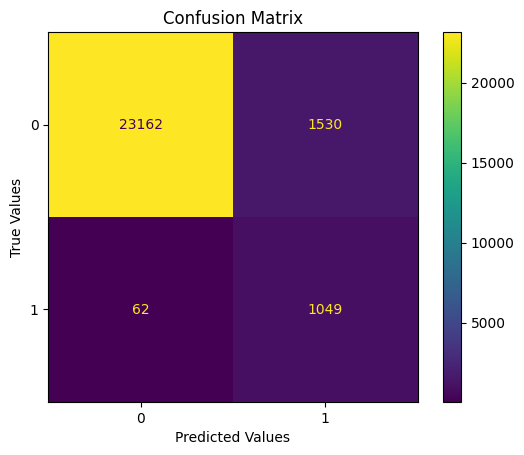

In [7]:
#cheking how well the optimized classifier (Random forest) perform on the test set

clf_best = RandomForestClassifier(min_samples_leaf=min_samples_leaf_best, max_features=max_features_best, random_state=42)
clf_best.fit(X_train, y_train)

scores_clf_best = clf_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_clf_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_clf_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_clf_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_clf_best))

#Making the confusion matrix
ConfusionMatrixDisplay.from_estimator(clf_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()



## Logistic Regression

In [8]:
# Imporing the classifier 
from sklearn.linear_model import LogisticRegression

In [9]:
# Converting X_train and y_train to numpy arrays
X_train_log, y_train_log = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_log_min = 0 
algorithm_best = ""
toleration_best = 0
regulation_best = 0 
iter_best = 0 

# Loop through different values of algorithm, toleration, regulation, and iteration
for algorithm in ['lbfgs', 'newton-cg']:
    for toleration in (1e-4, 1e-3, 1e-2):
        for regulation in (1e-1, 1e1):
            for iteration in (100, 1000):
                # Initialize average AUC score for this parameter combination
                average_auc = 0 
                
                # Perform k-fold cross-validation
                for train, test in kf.split(X_train_log):
                    # Split the data into training and testing sets for this fold
                    training_X, training_y = X_train_log[train], y_train_log[train]
                    test_X, test_y = X_train_log[test], y_train_log[test]
                    
                    # Initialize and train the Logistic Regression model
                    log = LogisticRegression(solver=algorithm, tol=toleration, C=regulation, random_state=42, max_iter=iteration)
                    log.fit(training_X, training_y)
                    
                    # Predict probabilities for the test set
                    scores_log = log.predict_proba(test_X)[:,1]

                    # Calculate AUC score for this fold
                    AUC_log = metrics.roc_auc_score(test_y, scores_log)
                    average_auc += AUC_log
                
                # Calculate the average AUC score across all folds
                average_auc /= kf.get_n_splits()
                
                # Update the best parameters and corresponding AUC if current parameters yield better result
                if average_auc > average_auc_log_min:
                    average_auc_log_min = average_auc 
                    algorithm_best = algorithm
                    toleration_best = toleration
                    regulation_best = regulation
                    iter_best = iteration
                    print(f"Solver {algorithm_best}, toleration {toleration_best}, regulation {regulation_best}, iteration {iter_best} gives the average AUC of {average_auc_log_min}")
 

Solver lbfgs, toleration 0.0001, regulation 0.1, iteration 100 gives the average AUC of 0.8936333192760256
Solver lbfgs, toleration 0.0001, regulation 10.0, iteration 1000 gives the average AUC of 0.8949959116131381
Solver lbfgs, toleration 0.001, regulation 10.0, iteration 1000 gives the average AUC of 0.8954220705608079
Solver newton-cg, toleration 0.0001, regulation 10.0, iteration 100 gives the average AUC of 0.8955619722521214


ACCURACY OF THE MODEL for Random forest: 0.861217687865752
PRECISION OF MODEL for Random forest: 0.2053912213740458
RECALL OF MODEL for Random forest: 0.774977497749775
F1-SCORE OF MODEL for Random forest: 0.3247218555534603


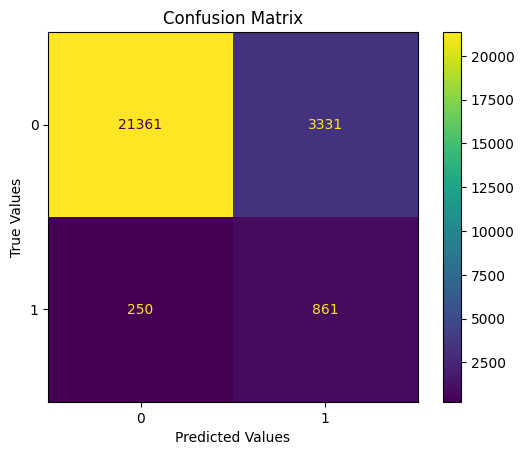

In [10]:
#cheking how well the optimized classifier (Logistic Regression) perform on the test set

log_best = LogisticRegression(solver = algorithm_best, tol = toleration_best, C= regulation_best, random_state = 42,  max_iter=iter_best)
log_best.fit(X_train, y_train)
scores_log_best = log_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_log_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_log_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_log_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_log_best))

#Making the confusion matrix
ConfusionMatrixDisplay.from_estimator(log_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

## Gradient Boosting Classifier

[This](https://aiml.com/what-are-the-key-hyper-parameters-for-a-gbm-model/) article defines *learning_rate* and *n_estimators* as the two most important hyperparameters

In [11]:
# Imporing the classifier 
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
# Converting X_train and y_train to numpy arrays
X_train_GBC, y_train_GBC = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_gbc_min = 0 
learning_rate_best = 0
n_estimators_best = 0

# Loop through different values of learning_rate and n_estimators
for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [2, 8, 16]:
        # Initialize average AUC score for this parameter combination
        average_auc = 0 
        # Perform k-fold cross-validation
        for train, test in kf.split(X_train_GBC):
            # Split the data into training and testing sets for this fold
            training_X , training_y = X_train_GBC[train], y_train_GBC[train]
            test_X, test_y = X_train_GBC[test], y_train_GBC[test]

            # Initialize and train the Gradient Boosting classifier
            gb = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
            gb.fit(training_X, training_y)
            
            # Predict probabilities for the test set
            scores_gb = gb.predict_proba(test_X)[:,1]

            # Calculate AUC score for this fold
            AUC_gb = metrics.roc_auc_score(test_y, scores_gb)
            average_auc += AUC_gb
            
        # Calculate the average AUC score across all folds
        average_auc /= kf.get_n_splits()
        
        # Update the best parameters and corresponding AUC if current parameters yield better result
        if average_auc > average_auc_gbc_min:
            average_auc_gbc_min = average_auc
            learning_rate_best = learning_rate
            n_estimators_best = n_estimators
            print(f"learning_rate: {learning_rate_best}, n_estimators: {n_estimators_best} gives the average AUC: {average_auc_gbc_min}")

learning_rate: 0.05, n_estimators: 2 gives the average AUC: 0.8699372303184326
learning_rate: 0.05, n_estimators: 8 gives the average AUC: 0.8909863071000736
learning_rate: 0.05, n_estimators: 16 gives the average AUC: 0.8998686678492681
learning_rate: 0.1, n_estimators: 8 gives the average AUC: 0.9011917124468541
learning_rate: 0.1, n_estimators: 16 gives the average AUC: 0.9147298173913705
learning_rate: 0.2, n_estimators: 16 gives the average AUC: 0.9283796028843924


ACCURACY OF THE MODEL for Random forest: 0.881525404022788
PRECISION OF MODEL for Random forest: 0.24408206207259336
RECALL OF MODEL for Random forest: 0.8352835283528353
F1-SCORE OF MODEL for Random forest: 0.37777325463057193


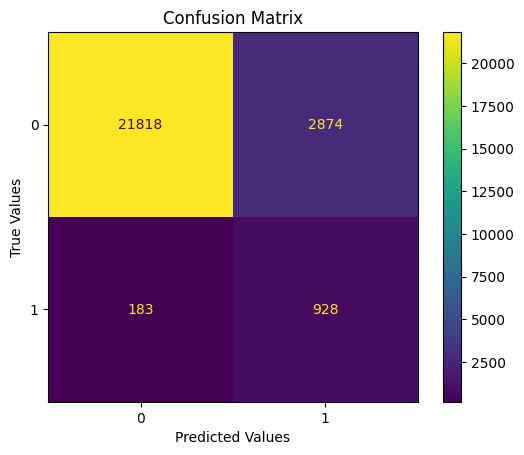

In [13]:
#cheking how well the optimized classifier (Gradient Boost) perform on the test set

gb_best = GradientBoostingClassifier(learning_rate=learning_rate_best,n_estimators=n_estimators_best ,random_state=42)
gb_best.fit(X_train, y_train)
scores_gb_best = gb_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_gb_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_gb_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_gb_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_gb_best))

#Making the confusion matrix
ConfusionMatrixDisplay.from_estimator(gb_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

## Ada Boost Classifier

[This](https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff) article defines *n_estimators* as the most important hyperparameter, with *learning_rate* and *base_estimator* as two other important ones. We will tweak n_estimators and learning_rate.

In [14]:
# Imporing the classifier 
from sklearn.ensemble import AdaBoostClassifier

In [15]:
# Converting X_train and y_train to numpy arrays
X_train_abc, y_train_abc = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_abc_min = 0 
learning_rate_best = 0
n_estimators_best = 0 

# Loop through different values of learning_rate and n_estimators
for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [2, 8, 16]:
        # Initialize average AUC score for this parameter combination
        average_auc = 0 
        # Perform k-fold cross-validation
        for train, test in kf.split(X_train_abc):
            # Split the data into training and testing sets for this fold
            training_X , training_y = X_train_abc[train], y_train_abc[train]
            test_X, test_y = X_train_abc[test], y_train_abc[test]

            # Initialize and train the AdaBoost classifier
            abc = AdaBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
            abc.fit(training_X, training_y)
            
            # Predict probabilities for the test set
            scores_abc = abc.predict_proba(test_X)[:,1]

            # Calculate AUC score for this fold
            AUC_abc = metrics.roc_auc_score(test_y, scores_abc)
            average_auc += AUC_abc

        # Calculate the average AUC score across all folds
        average_auc /= kf.get_n_splits()
        
        # Update the best parameters and corresponding AUC if current parameters yield better result
        if average_auc > average_auc_abc_min:
            average_auc_abc_min = average_auc
            learning_rate_best = learning_rate
            n_estimators_best = n_estimators
            print(f"learning_rate: {learning_rate_best}, n_estimators: {n_estimators_best} gives the average AUC: {average_auc_abc_min}")
            

learning_rate: 0.05, n_estimators: 2 gives the average AUC: 0.7533429539150264
learning_rate: 0.05, n_estimators: 8 gives the average AUC: 0.8183697866134644
learning_rate: 0.05, n_estimators: 16 gives the average AUC: 0.8204132282322719
learning_rate: 0.1, n_estimators: 8 gives the average AUC: 0.8206033562488239
learning_rate: 0.1, n_estimators: 16 gives the average AUC: 0.8609239691894102
learning_rate: 0.2, n_estimators: 16 gives the average AUC: 0.877246592869925


ACCURACY OF THE MODEL for Random forest: 0.820989807386738
PRECISION OF MODEL for Random forest: 0.17214953271028038
RECALL OF MODEL for Random forest: 0.828982898289829
F1-SCORE OF MODEL for Random forest: 0.2850951865036372


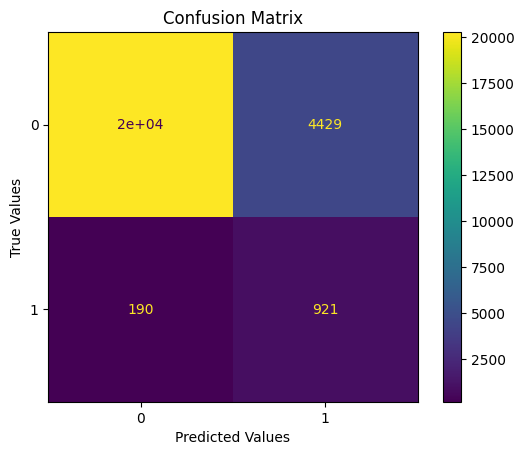

In [16]:
#cheking how well the optimized classifier (Ada boost) perform on the test set

abc_best = AdaBoostClassifier(learning_rate=learning_rate_best, n_estimators=n_estimators_best,random_state=42)
abc_best.fit(X_train, y_train)
scores_abc_best = abc_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_abc_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_abc_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_abc_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_abc_best))

#Making the confusion matrix
ConfusionMatrixDisplay.from_estimator(abc_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()